In [1]:
!pip install keras-cv tensorflow --upgrade

In [2]:
!wget http://saliencydetection.net/duts/download/DUTS-TE.zip

--2023-08-15 10:50:42--  http://saliencydetection.net/duts/download/DUTS-TE.zip
Resolving saliencydetection.net (saliencydetection.net)... 36.55.239.177
Connecting to saliencydetection.net (saliencydetection.net)|36.55.239.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139799089 (133M) [application/zip]
Saving to: ‘DUTS-TE.zip.1’

DUTS-TE.zip.1       100%[===================>] 133.32M  5.06MB/s    in 27s     

2023-08-15 10:51:09 (4.94 MB/s) - ‘DUTS-TE.zip.1’ saved [139799089/139799089]



In [3]:
!unzip DUTS-TE.zip

Streaming output truncated to the last 5000 lines.
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00066215.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00082351.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00082798.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00006593.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00011235.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00082541.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00070363.png  
  inflating: DUTS-TE/DUTS-TE-Mask/sun_bceuokyqoqhfsper.png  
  inflating: DUTS-TE/DUTS-TE-Mask/sun_abydfmdyqyieeram.png  
 extracting: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00070467.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00081849.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2013_test_00002195.png  
  inflating: DUTS-TE/DUTS-TE-Mask/sun_birvjjkruobbrzse.png  
  inflating: DUTS-TE/DUTS-TE-Mask/sun_aeraygrwrxmiozxx.png  
  inflating: DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00091

In [6]:
!pip install git+https://github.com/keras-team/keras-cv.git tensorflow --upgrade

  Cloning https://github.com/keras-team/keras-cv.git to /tmp/pip-req-build-phzcs8na
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv.git /tmp/pip-req-build-phzcs8na
  Resolved https://github.com/keras-team/keras-cv.git to commit 2a704e1a69cc46c808209f45ce19f311b05fe19d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 15.0 MB/s eta 0:00:00


In [7]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras_cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend

Using TensorFlow backend


In [8]:
IMAGE_SIZE = 288
BATCH_SIZE = 4
OUT_CLASSES = 1
TRAIN_SPLIT_RATIO = 0.90
DATA_DIR = "./DUTS-TE/"

In [9]:
def load_paths(path, split_ratio):
    images = sorted(glob(os.path.join(path, "DUTS-TE-Image/*")))[:140]
    masks = sorted(glob(os.path.join(path, "DUTS-TE-Mask/*")))[:140]
    len_ = int(len(images) * split_ratio)
    return (images[:len_], masks[:len_]), (images[len_:], masks[len_:])


def read_image(path, size, mode):
    x = keras.utils.load_img(path, target_size=size, color_mode=mode)
    x = keras.utils.img_to_array(x)
    x = (x / 255.0).astype(np.float32)
    return x


def preprocess(x_batch, y_batch, img_size, out_classes):
    def f(_x, _y):
        _x, _y = _x.decode(), _y.decode()
        _x = read_image(_x, (img_size, img_size), mode="rgb")  # image
        _y = read_image(_y, (img_size, img_size), mode="grayscale")  # mask
        return _x, _y

    images, masks = tf.numpy_function(f, [x_batch, y_batch], [tf.float32, tf.float32])
    images.set_shape([img_size, img_size, 3])
    masks.set_shape([img_size, img_size, out_classes])
    return images, masks


def load_dataset(image_paths, mask_paths, img_size, out_classes, batch, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size=1000)
    dataset = dataset.map(
        lambda x, y: preprocess(x, y, img_size, out_classes),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_paths, val_paths = load_paths(DATA_DIR, TRAIN_SPLIT_RATIO)

train_dataset = load_dataset(
    train_paths[0], train_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=True
)
val_dataset = load_dataset(
    val_paths[0], val_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=False
)

print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")

Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))>


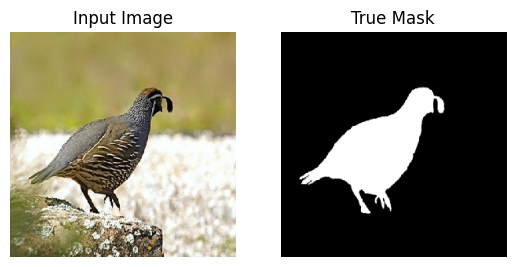

In [10]:
def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i]), cmap="gray")
        plt.axis("off")
    plt.show()


for image, mask in val_dataset.take(1):
    display([image[0], mask[0]])

In [11]:
print(f"Unique values count: {len(np.unique((mask[0] * 255)))}")
print("Unique values:")
print(np.unique((mask[0] * 255)).astype(int))

Unique values count: 245
Unique values:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  61  62  63  65  66  67  68  69  70  71  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 108 109 110 111 112
 113 114 115 116 117 118 119 120 122 123 124 125 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 24

In [12]:
def basic_block(x_input, filters, stride=1, down_sample=None, activation=None):
    """Creates a residual(identity) block with two 3*3 convolutions."""
    residual = x_input

    x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", use_bias=False)(
        x_input
    )
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", use_bias=False)(
        x
    )
    x = layers.BatchNormalization()(x)

    if down_sample is not None:
        residual = down_sample

    x = layers.Add()([x, residual])

    if activation is not None:
        x = layers.Activation(activation)(x)

    return x


def convolution_block(x_input, filters, dilation=1):
    """Apply convolution + batch normalization + relu layer."""
    x = layers.Conv2D(filters, (3, 3), padding="same", dilation_rate=dilation)(x_input)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)


def segmentation_head(x_input, out_classes, final_size):
    """Map each decoder stage output to model output classes."""
    x = layers.Conv2D(out_classes, kernel_size=(3, 3), padding="same")(x_input)

    if final_size is not None:
        x = layers.Resizing(final_size[0], final_size[1])(x)

    return x


def get_resnet_block(_resnet, block_num):
    """Extract and return ResNet-34 block."""
    resnet_layers = [3, 4, 6, 3]  # ResNet-34 layer sizes at different block.
    return keras.models.Model(
        inputs=_resnet.get_layer(f"v2_stack_{block_num}_block1_1_conv").input,
        outputs=_resnet.get_layer(
            f"v2_stack_{block_num}_block{resnet_layers[block_num]}_add"
        ).output,
        name=f"resnet34_block{block_num + 1}",
    )

In [13]:
def basnet_predict(input_shape, out_classes):
    """BASNet Prediction Module, it outputs coarse label map."""
    filters = 64
    num_stages = 6

    x_input = layers.Input(input_shape)

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    resnet = keras_cv.models.ResNet34Backbone(
        include_rescaling=False,
    )

    encoder_blocks = []
    for i in range(num_stages):
        if i < 4:  # First four stages are adopted from ResNet-34 blocks.
            x = get_resnet_block(resnet, i)(x)
            encoder_blocks.append(x)
            x = layers.Activation("relu")(x)
        else:  # Last 2 stages consist of three basic resnet blocks.
            x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            encoder_blocks.append(x)

    # -------------Bridge-------------
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    encoder_blocks.append(x)

    # -------------Decoder-------------
    decoder_blocks = []
    for i in reversed(range(num_stages)):
        if i != (num_stages - 1):  # Except first, scale other decoder stages.
            shape = keras.backend.int_shape(x)
            x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)

        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        decoder_blocks.append(x)

    decoder_blocks.reverse()  # Change order from last to first decoder stage.
    decoder_blocks.append(encoder_blocks[-1])  # Copy bridge to decoder.

    # -------------Side Outputs--------------
    decoder_blocks = [
        segmentation_head(decoder_block, out_classes, input_shape[:2])
        for decoder_block in decoder_blocks
    ]

    return keras.models.Model(inputs=[x_input], outputs=decoder_blocks)

In [14]:
def basnet_rrm(base_model, out_classes):
    """BASNet Residual Refinement Module(RRM) module, output fine label map."""
    num_stages = 4
    filters = 64

    x_input = base_model.output[0]

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    encoder_blocks = []
    for _ in range(num_stages):
        x = convolution_block(x, filters=filters)
        encoder_blocks.append(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    # -------------Bridge--------------
    x = convolution_block(x, filters=filters)

    # -------------Decoder--------------
    for i in reversed(range(num_stages)):
        shape = keras.backend.int_shape(x)
        x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)
        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters)

    x = segmentation_head(x, out_classes, None)  # Segmentation head.

    # ------------- refined = coarse + residual
    x = layers.Add()([x_input, x])  # Add prediction + refinement output

    return keras.models.Model(inputs=[base_model.input], outputs=[x])

In [15]:
def basnet(input_shape, out_classes):
    """BASNet, it's a combination of two modules
    Prediction Module and Residual Refinement Module(RRM)."""

    # Prediction model.
    predict_model = basnet_predict(input_shape, out_classes)
    # Refinement model.
    refine_model = basnet_rrm(predict_model, out_classes)

    output = [refine_model.output]  # Combine outputs.
    output.extend(predict_model.output)

    output = [layers.Activation("sigmoid")(_) for _ in output]  # Activations.

    return keras.models.Model(inputs=[predict_model.input], outputs=output)

In [16]:
class BasnetLoss(keras.losses.Loss):
    """BASNet hybrid loss."""

    def __init__(self, **kwargs):
        super().__init__(name="basnet_loss", **kwargs)
        self.smooth = 1.0e-9

        # Binary Cross Entropy loss.
        self.cross_entropy_loss = keras.losses.BinaryCrossentropy()
        # Structural Similarity Index value.
        self.ssim_value = tf.image.ssim
        #  Jaccard / IoU loss.
        self.iou_value = self.calculate_iou

    def calculate_iou(
        self,
        y_true,
        y_pred,
    ):
        """Calculate intersection over union (IoU) between images."""
        intersection = backend.sum(backend.abs(y_true * y_pred), axis=[1, 2, 3])
        union = backend.sum(y_true, [1, 2, 3]) + backend.sum(y_pred, [1, 2, 3])
        union = union - intersection
        return backend.mean(
            (intersection + self.smooth) / (union + self.smooth), axis=0
        )

    def call(self, y_true, y_pred):
        cross_entropy_loss = self.cross_entropy_loss(y_true, y_pred)

        ssim_value = self.ssim_value(y_true, y_pred, max_val=1)
        ssim_loss = backend.mean(1 - ssim_value + self.smooth, axis=0)

        iou_value = self.iou_value(y_true, y_pred)
        iou_loss = 1 - iou_value

        # Add all three losses.
        return cross_entropy_loss + ssim_loss + iou_loss


basnet_model = basnet(
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], out_classes=OUT_CLASSES
)  # Create model.
basnet_model.summary()  # Show model summary.

optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
# Compile model.
basnet_model.compile(
    loss=BasnetLoss(),
    optimizer=optimizer,
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 288, 288, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 288, 288, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 resnet34_block1 (Functiona  (None, None, None, 64)       222720    ['conv2d[0][0]']              
 l)                                                                                               
                                                                                                  
 activation (Activation)     (None, 288, 288, 64)         0         ['resnet34_block1[0][0]'

In [17]:
basnet_model.fit(train_dataset, validation_data=val_dataset, epochs=1)

32/32 [==============================] - 360s 7s/step - loss: 16.9834 - activation_46_loss: 2.1487 - activation_47_loss: 2.2533 - activation_48_loss: 2.1612 - activation_49_loss: 2.2007 - activation_50_loss: 2.1865 - activation_51_loss: 2.0487 - activation_52_loss: 1.9378 - activation_53_loss: 2.0465 - activation_46_mae: 0.2603 - activation_47_mae: 0.3185 - activation_48_mae: 0.2958 - activation_49_mae: 0.3154 - activation_50_mae: 0.3111 - activation_51_mae: 0.2761 - activation_52_mae: 0.2333 - activation_53_mae: 0.2628 - val_loss: 19.7184 - val_activation_46_loss: 2.7926 - val_activation_47_loss: 2.9522 - val_activation_48_loss: 2.4689 - val_activation_49_loss: 2.2812 - val_activation_50_loss: 2.3688 - val_activation_51_loss: 2.3564 - val_activation_52_loss: 2.2753 - val_activation_53_loss: 2.2229 - val_activation_46_mae: 0.5483 - val_activation_47_mae: 0.5981 - val_activation_48_mae: 0.4811 - val_activation_49_mae: 0.3259 - val_activation_50_mae: 0.2116 - val_activation_51_mae: 0.190

In [18]:
!!gdown 1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg

['Downloading...',
 'From: https://drive.google.com/uc?id=1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg',
 'To: /content/basnet_weights.h5',
 '',
 '  0% 0.00/436M [00:00<?, ?B/s]',
 '  1% 4.72M/436M [00:00<00:12, 33.2MB/s]',
 '  4% 17.3M/436M [00:00<00:06, 67.9MB/s]',
 '  8% 34.1M/436M [00:00<00:06, 63.7MB/s]',
 ' 12% 50.9M/436M [00:00<00:06, 62.2MB/s]',
 ' 16% 67.6M/436M [00:00<00:04, 77.4MB/s]',
 ' 19% 83.9M/436M [00:01<00:03, 94.5MB/s]',
 ' 22% 94.9M/436M [00:01<00:03, 88.8MB/s]',
 ' 24% 105M/436M [00:01<00:05, 62.7MB/s] ',
 ' 26% 113M/436M [00:01<00:05, 64.3MB/s]',
 ' 28% 121M/436M [00:01<00:04, 65.9MB/s]',
 ' 29% 128M/436M [00:01<00:04, 67.0MB/s]',
 ' 31% 136M/436M [00:02<00:05, 53.0MB/s]',
 ' 33% 143M/436M [00:02<00:05, 57.2MB/s]',
 ' 35% 152M/436M [00:02<00:04, 62.6MB/s]',
 ' 37% 159M/436M [00:02<00:04, 65.5MB/s]',
 ' 38% 167M/436M [00:02<00:04, 65.6MB/s]',
 ' 40% 174M/436M [00:02<00:03, 65.7MB/s]',
 ' 42% 185M/436M [00:02<00:03, 63.3MB/s]',
 ' 46% 202M/436M [00:02<00:02, 78.4MB/s]',
 ' 48%

In [19]:
def normalize_output(prediction):
    max_value = np.max(prediction)
    min_value = np.min(prediction)
    return (prediction - min_value) / (max_value - min_value)


# Load weights.
basnet_model.load_weights("./basnet_weights.h5")

1/1 [==============================] - 2s 2s/step


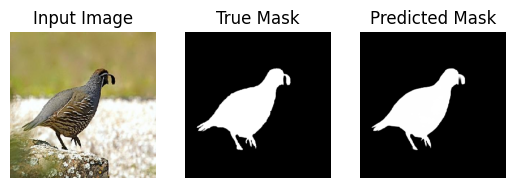

In [20]:
for image, mask in val_dataset.take(1):
    pred_mask = basnet_model.predict(image)
    display([image[0], mask[0], normalize_output(pred_mask[0][0])])